In [1]:
%matplotlib inline

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

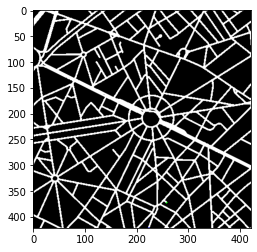

In [2]:
image = Image.open('urban grids/paris.png')
size = image.size
data = np.asarray(image)
plt.imshow(image)

In [3]:
FREE_CELL = 0
OBSTACLE = 1
START = 2
GOAL = 3
L = 9

In [4]:
BLACK = [0, 0, 0]
WHITE = [255, 255, 255, 255]
RED = [255, 0, 0]
BLUE = [0, 0, 255]
GREEN = [0, 255, 0]
cell_types = np.zeros(size, dtype=int)
for x in range(size[0]):
    for y in range(size[1]):
        if np.array_equal(data[x, y, :], BLACK):
            cell_types[x, y] = OBSTACLE
        elif np.array_equal(data[x, y, :], WHITE):
            cell_types[x, y] = 0
        elif np.array_equal(data[x, y, :], GREEN):
            cell_types[x, y] = 2
        elif np.array_equal(data[x, y, :], BLUE):
            cell_types[x, y] = 3

start = np.copy(cell_types)
start = np.where(start != START, 0, start)
start = np.where(start == START, 1, start)
start_coords = np.argwhere(start == 1).transpose()

goal = np.copy(cell_types)
goal = np.where(goal != GOAL, 0, goal)
goal = np.where(goal == GOAL, 1, goal)
goal_coords = np.argwhere(goal == 1).transpose()

In [5]:
def is_out_of_bounds(new_index):
    return np.any(np.array(new_index) > (np.array(size) - 1)) or np.any(np.array(new_index) < 0)

In [6]:
moves = [
    lambda x, y: (np.clip(x - 1, 0, size[0] - 1), y),  # Up
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y + 1)) else (x - 1, y + 1),  # Up-Right
    lambda x, y: (x, np.clip(y + 1, 0, size[0] - 1)),  # Right
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y + 1)) else (x + 1, y + 1),  # Down-Right
    lambda x, y: (np.clip(x + 1, 0, size[0] - 1), y),  # Down
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y - 1)) else (x + 1, y - 1),  # Down-Left
    lambda x, y: (x, np.clip(y - 1, 0, size[0] - 1)),  # Left
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y - 1)) else (x - 1, y - 1),  # Up-Left
    lambda x, y: (x, y),  # Still
]

In [7]:
n_actions = 9
distr = np.ones((n_actions, n_actions))
for action in range(n_actions):
    if action == 8:
        distr[action] = np.ones(n_actions) / ((n_actions - 1) * 2)
        distr[action, 8] = 1 / 2
    else:
        distr[action] = np.ones(n_actions) / (n_actions * 2)
        distr[action, action] = 1 / 3

        next_action = action + 1 if action + 1 < n_actions - 1 else 0
        distr[action][next_action] = 1 / 6

        next_action = action - 1 if action > 0 else n_actions - 2
        distr[action][next_action] = 1 / 6

In [8]:
def has_obstacles_nearby(x, y):
    obstacles = []
    for i in range(n_actions):
        if cell_types[moves[i](x, y)] == 1:
            obstacles.append(i)
    return obstacles


def state_trnstn_distr(x, y, action):
    distr2 = np.copy(distr[action])
    obstacles = has_obstacles_nearby(x, y)
    if obstacles:
        prob = 0
        for obs in obstacles:
            prob += distr2[obs]
            distr2[obs] = 0
        for i, p_i in enumerate(distr2):
            if i not in obstacles:
                distr2[i] = p_i / (1 - prob)

    reshaped_distr = np.zeros(distr2.shape)
    reshaped_distr[0] = distr2[7]
    reshaped_distr[1] = distr2[0]
    reshaped_distr[2] = distr2[1]
    reshaped_distr[3] = distr2[6]
    reshaped_distr[4] = distr2[8]
    reshaped_distr[5] = distr2[2]
    reshaped_distr[6] = distr2[5]
    reshaped_distr[7] = distr2[4]
    reshaped_distr[8] = distr2[3]
    reshaped_distr = reshaped_distr.reshape((3, 3))
    return reshaped_distr

In [9]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [10]:
finished = False


def generator():
    i = 1
    while not finished:
        yield i
        i += 1

In [11]:
## Backward
bas = np.zeros((size[0], size[1], L, 1))
bs = np.zeros((size[0], size[1], 1))
ba = np.zeros((L, 1))
bs[:, :, 0] = goal

ba[:, 0] = np.ones(L) / L

for a in range(L):
    bas[:, :, a, 0] = bs[:, :, 0] * ba[a, 0]
bas[:, :, :, 0] /= np.sum(bas[:, :, :, 0])
p_bar = tqdm(generator(), desc="t")
for t in p_bar:
    bas = np.append(bas, np.zeros((size[0], size[1], L, 1)), axis=3)
    bs = np.append(bs, np.zeros((size[0], size[1], 1)), axis=2)
    for l in range(L):
        indexes = np.transpose(np.sum(bas[:, :, :, t - 1], axis=2).nonzero())
        new_indexes = list(totuple(indexes))
        for index in indexes:
            x = index[0]
            y = index[1]
            for a in range(9):
                new_index = moves[a](x, y)
                new_indexes.append(new_index)

        new_indexes = list(dict.fromkeys(new_indexes))
        for index in new_indexes:
            x = index[0]
            y = index[1]
            if x == 0 or x == size[0] - 1 or y == 0 or y == size[1] - 1:
                continue
            skip = 1
            if cell_types[x, y] == OBSTACLE:
                skip = 0
            mask = state_trnstn_distr(x, y, l)
            for a in range(L):
                bas[x, y, l, t] = skip * (bas[x, y, l, t] + np.sum(
                    mask * bas[x - 1:x + 2, y - 1:y + 2, a, t - 1]) / n_actions)

    bas[:, :, :, t] /= np.sum(bas[:, :, :, t])
    bs[:, :, t] = np.sum(bas[:, :, :, t], 2)
    start_check = bs[:, :, t]
    start_check = start_check[start_coords[0], start_coords[1]]
    if np.any(start_check > 0):
        finished = True
        T = t + 1


t: 0it [00:00, ?it/s]

t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]

MoviePy - Building file test.gif with imageio.



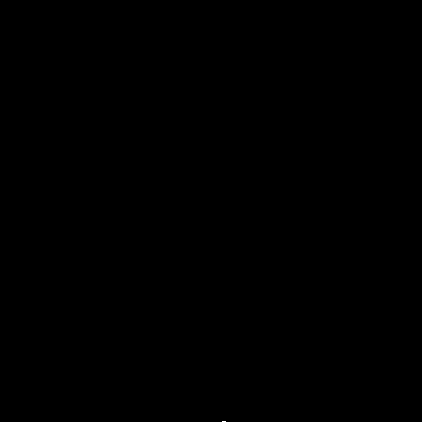

In [12]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


from moviepy.editor import ImageSequenceClip

frames = np.moveaxis(bs[:, :, 0:T - 1], 2, 0).reshape((T - 1, 422, 422, 1)) * 255
frames=np.where(frames>0, 255, 0)
#frames = 255.0 - (255.0 * normalize(frames) + 255.0)
clip = ImageSequenceClip(list(frames), fps=30)
clip.write_gif('test.gif', fps=30)


def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


show_gif('test.gif')

In [13]:
fas = np.zeros((size[0], size[1], L, 1))
fs = np.zeros((size[0], size[1], 1))
fa = np.zeros((L, 1))
fs[:, :, 0] = start
fa[:, 0] = np.ones(L) / L
for a in range(L):
    fas[:, :, a, 0] = fs[:, :, 0] * fa[a, 0]

k = fas[:, :, :, 0] * bas[:, :, :, T-1]
path = np.zeros((size[0], size[1]))
idmax = np.argwhere(k == np.max(k)).transpose()
newfas = np.zeros((size[0], size[1], L))
newfas[idmax[0], idmax[1], idmax[2]] = 1
path[idmax[0], idmax[1]] = 1
#fas = np.zeros((size[0], size[1], L, 1))

for t in tqdm(range(1, T)):
    fas = np.append(fas, np.zeros((size[0], size[1], L, 1)), axis=3)
    fs = np.append(fs, np.zeros((size[0], size[1], 1)), axis=2)
    for l in range(L):
        indexes = np.transpose(np.sum(fas[:, :, :, t - 1], axis=2).nonzero())
        new_indexes = list(totuple(indexes))
        for index in indexes:
            x = index[0]
            y = index[1]
            for a in range(9):
                new_index = moves[a](x, y)
                new_indexes.append(new_index)

            new_indexes = list(dict.fromkeys(new_indexes))
            for index in new_indexes:
                x = index[0]
                y = index[1]
                if x == 0 or x == size[0] - 1 or y == 0 or y == size[1] - 1:
                    continue
                mask = state_trnstn_distr(x, y, l)
                for a in range(n_actions):
                    fas[x - 1:x + 2, y - 1:y + 2, a, t] += mask * newfas[x, y, l] / n_actions

    k = fas[:, :, :, t] * bas[:, :, :, T-t-1]
    idmax = np.argwhere(k == np.max(k)).transpose()
    newfas = np.zeros((size[0], size[0], L))
    newfas[idmax[0], idmax[1], idmax[2]] = 1
    path[idmax[0], idmax[1]] = 1

  0%|          | 0/57 [00:00<?, ?it/s]

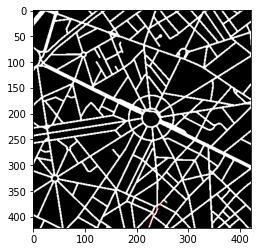

In [14]:
new_image = np.copy(data)
path_indexes = np.argwhere(path==1).transpose()
new_image[path_indexes[0], path_indexes[1],:] = RED
plt.imshow(new_image)
Image.fromarray(new_image).save("path.png")